In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import batman
import sys
import copy
import time
from astropy import units as u
from astropy.constants import G
from astropy.io import ascii
from matplotlib import gridspec
import matplotlib as mpl

%matplotlib inline

In [2]:
kep = ascii.read("../jstutorials/plotKepler/KOIarchive.csv")
print kep

rowid  kepid   kepoi_name ... koi_dikco_msky koi_dikco_msky_err
----- -------- ---------- ... -------------- ------------------
    1 10797460  K00752.01 ...           0.32               0.16
    2 10797460  K00752.02 ...            0.5               0.45
    5 10854555  K00755.01 ...           0.07                0.2
    6 10872983  K00756.01 ...           0.08                0.1
    7 10872983  K00756.02 ...           0.19               0.17
    8 10872983  K00756.03 ...            0.5                0.3
   10 10910878  K00757.01 ...          0.031              0.081
   11 11446443  K00001.01 ...           0.27               0.17
   12 10666592  K00002.01 ...           4.19               0.75
   13  6922244  K00010.01 ...          0.178              0.068
  ...      ...        ... ...            ...                ...
 9534 10028127  K08193.01 ...           0.32               0.48
 9540 12885212  K02184.02 ...           0.83               0.63
 9541  3645438  K04385.02 ...           

In [3]:
kepstellar = ascii.read("./kepler_stellar_17.csv")
print kepstellar

  kepid        tm_designation     teff ... timeoutsumry cdppslplong cdppslpshrt
--------- ----------------------- ---- ... ------------ ----------- -----------
   757076 2MASS J19240929+3635532 5160 ...            1    -0.33009    -0.41285
   757099 2MASS J19241033+3635377 5519 ...            0    -0.25653    -0.18629
   757137 2MASS J19241341+3633358 4706 ...            0     0.22699     0.67461
   757280 2MASS J19242289+3633538 6543 ...            1    -0.10948    -0.37236
   757450 2MASS J19243302+3634385 5332 ...            1    -0.11868    -0.48642
   891901 2MASS J19234924+3641212 6323 ...            1    -0.16524    -0.58685
   891916 2MASS J19234997+3641118 5602 ...            1     0.28699     -0.3707
   892010 2MASS J19235545+3640011 4729 ...            1      0.2137     1.04503
   892107 2MASS J19240024+3638334 5080 ...            1    -0.34153    -0.42588
   892195 2MASS J19240520+3638374 5522 ...            1    -0.22849    -0.66485
      ...                     ...  ... .

In [4]:
print len(kep.colnames)
print kep.colnames
print len(kepstellar.colnames)
print kepstellar.colnames

141
['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_time0', 'koi_time0_err1', 'koi_time0_err2', 'koi_eccen', 'koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_ror', 'koi_ror_err1', 'koi_ror_err2', 'koi_srho', 'koi_srho_err1', 'koi_srho_err2', 'koi_fittype', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_sma', 'koi_sma_err1', 'koi_sma_err2', 'koi_incl', 'koi_incl_err1', 'koi_incl_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', '

In [25]:
cols_to_add = ['dist','dist_err1','dist_err2','nconfp','nkoi']

(array([  4.14400000e+03,   3.07400000e+03,   4.84900000e+03,
          6.83600000e+03,   9.77100000e+03,   1.28730000e+04,
          1.63560000e+04,   1.85790000e+04,   1.96430000e+04,
          1.85630000e+04,   1.63030000e+04,   1.35270000e+04,
          1.07650000e+04,   8.18500000e+03,   5.92500000e+03,
          4.28300000e+03,   3.09900000e+03,   2.34000000e+03,
          1.66900000e+03,   1.33700000e+03,   1.07900000e+03,
          8.81000000e+02,   8.41000000e+02,   7.02000000e+02,
          6.96000000e+02,   6.34000000e+02,   5.84000000e+02,
          5.59000000e+02,   5.33000000e+02,   4.56000000e+02,
          4.53000000e+02,   4.79000000e+02,   4.15000000e+02,
          3.70000000e+02,   3.69000000e+02,   3.74000000e+02,
          3.06000000e+02,   3.16000000e+02,   2.92000000e+02,
          3.08000000e+02,   2.76000000e+02,   2.59000000e+02,
          2.45000000e+02,   2.43000000e+02,   2.21000000e+02,
          2.22000000e+02,   1.98000000e+02,   1.50000000e+02,
        

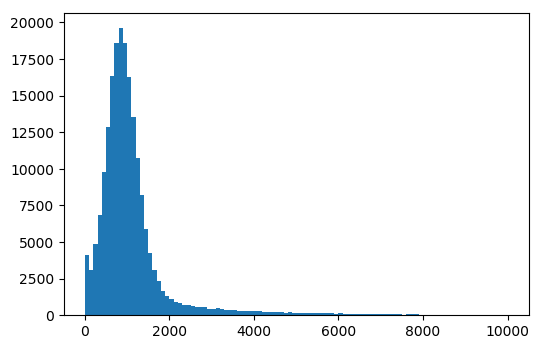

In [7]:
plt.hist(kepstellar['dist'],range=(0,10000),bins=100)

In [28]:
kepstellar_idxs = []
for i in range(0,len(kep)):
    kic = kep['kepid'][i]
    kepstellar_mask = (kepstellar['kepid'] == kic)
    try:
        kepstellar_idxs.append(np.arange(0,len(kepstellar))[kepstellar_mask][0])
    except IndexError:
        print kic
        print np.arange(0,len(kepstellar))[kepstellar_mask]
        kepstellar_idxs.append(np.arange(0,len(kepstellar))[kepstellar_mask])
        
kepstellar_idxs = np.array(kepstellar_idxs)
print np.shape(kepstellar_idxs)
print kepstellar_idxs

(4496,)
[168178 168178 169246 ..., 190689 118625 153253]


In [33]:
for newcol in cols_to_add:
    kep[newcol] = kepstellar[newcol][kepstellar_idxs]

In [37]:
#print kep
print kep['kepid','dist']

 kepid     dist 
-------- -------
10797460 1014.04
10797460 1014.04
10854555 1459.17
10872983  1435.0
10872983  1435.0
10872983  1435.0
10910878  963.24
11446443  198.51
10666592  324.82
 6922244  918.89
     ...     ...
10028127 1115.66
12885212  636.49
 3645438   943.4
 4548098  485.67
10467815 1432.01
 7429287  281.81
 8488381   693.1
 8489260 1352.31
11911561  805.46
 8765560 1234.97
10128825 1046.16
Length = 4496 rows


In [40]:
kep.write("./KOIarchive_stellar.csv",format='ascii',delimiter=',')